In [1]:
using Evolutionary
using Flux
using Flux: onehot, onecold, logitcrossentropy #, throttle, @epochs
using MLDatasets
using Random
using StableRNGs

In [84]:
using ZipFile, CSV, DataFrames, Random, StatsBase , Plots, Statistics

# read file from zip archive

z = ZipFile.Reader("results.zip")

# identify the right file in zip

# The diabetes dataset I found through kaggle have done split into 2 classifiers and select 50 percents of result from each 
# label. So i think there is more work in my dataset

a_file_in_zip = filter(x->x.name == "diabetes_binary_5050split_health_indicators_BRFSS2015.csv", z.files)[1]

#avoid changing the original files in the zip file. However, the dataset will not change but whatever.

a_copy = CSV.File(a_file_in_zip) |> DataFrame

close(z)

#show the dataset

a_copy

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,1.0,1.0,25.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0
3,0.0,1.0,1.0,1.0,29.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,26.0,1.0,0.0,0.0
5,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0
6,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0
7,0.0,1.0,1.0,1.0,36.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,26.0,1.0,0.0,0.0
9,0.0,0.0,0.0,1.0,21.0,0.0,0.0,0.0


In [85]:
# Transfer DataFrame to matrix form

df=a_copy|>Tables.matrix

# Transfer the dataset to 2-classifiers. df_0 represents the result is 0, df_1 represents the result is 1.
# Due to my datasset is binary problems, and each result is 50 percents of the whole dataset. So i didn't add any other pre-actions for dataset. 

df_0 = df[df[:,1] .== 0, :]
df_1 = df[df[:,1] .== 1, :]

35346×22 Matrix{Float64}:
 1.0  1.0  1.0  1.0  30.0  1.0  0.0  1.0  …  30.0  1.0  0.0   9.0  5.0  1.0
 1.0  0.0  0.0  1.0  25.0  1.0  0.0  0.0      0.0  0.0  1.0  13.0  6.0  8.0
 1.0  1.0  1.0  1.0  28.0  0.0  0.0  0.0      0.0  1.0  0.0  11.0  4.0  6.0
 1.0  0.0  0.0  1.0  23.0  1.0  0.0  0.0      0.0  0.0  1.0   7.0  5.0  6.0
 1.0  1.0  0.0  1.0  27.0  0.0  0.0  0.0      0.0  0.0  0.0  13.0  5.0  4.0
 1.0  1.0  1.0  1.0  37.0  1.0  1.0  1.0  …   0.0  1.0  1.0  10.0  6.0  5.0
 1.0  1.0  1.0  1.0  28.0  1.0  0.0  1.0      0.0  0.0  1.0  12.0  2.0  4.0
 1.0  1.0  1.0  1.0  27.0  1.0  0.0  0.0     20.0  1.0  0.0   8.0  4.0  7.0
 1.0  1.0  1.0  1.0  34.0  1.0  1.0  0.0      7.0  1.0  0.0   9.0  5.0  4.0
 1.0  1.0  1.0  1.0  24.0  1.0  0.0  0.0      0.0  0.0  0.0  12.0  3.0  3.0
 1.0  1.0  0.0  1.0  31.0  0.0  0.0  0.0  …   5.0  0.0  0.0  13.0  4.0  4.0
 1.0  1.0  1.0  1.0  33.0  1.0  0.0  0.0     30.0  1.0  0.0  11.0  4.0  2.0
 1.0  1.0  1.0  1.0  27.0  1.0  0.0  0.0     30.0  1.0  0.0  1

In [86]:
# The columns of matrix is 35346(here just using 35000 is the same), using random sub-sequence to select 70 percents of 
# columns as the train data.

sample = randsubseq(1:35000, 0.7)
train_df = vcat(df_0[sample, :], df_1[sample, :])

# Then from the not selected columns (which is 30 percents) to select the test data.

notsample = [i for i in 1:35000 if isempty(searchsorted(sample, i))]
test_df = vcat(df_0[notsample, :], df_1[notsample, :])

20904×22 Matrix{Float64}:
 0.0  0.0  1.0  1.0  25.0  1.0  0.0  0.0  …   2.0  0.0  0.0  11.0  5.0  7.0
 0.0  1.0  1.0  1.0  29.0  1.0  0.0  0.0      1.0  0.0  1.0  13.0  5.0  8.0
 0.0  0.0  0.0  1.0  26.0  1.0  0.0  0.0      0.0  0.0  1.0   7.0  6.0  8.0
 0.0  0.0  0.0  1.0  29.0  1.0  0.0  0.0      0.0  0.0  1.0   4.0  4.0  4.0
 0.0  0.0  0.0  0.0  24.0  0.0  0.0  0.0      0.0  0.0  1.0   7.0  5.0  8.0
 0.0  1.0  1.0  1.0  23.0  1.0  0.0  1.0  …   0.0  0.0  0.0   6.0  4.0  6.0
 0.0  1.0  1.0  1.0  26.0  1.0  0.0  1.0     15.0  1.0  1.0   9.0  3.0  3.0
 0.0  0.0  0.0  1.0  35.0  0.0  0.0  0.0      0.0  0.0  1.0   7.0  4.0  7.0
 0.0  0.0  0.0  1.0  25.0  0.0  0.0  0.0      0.0  0.0  1.0   4.0  6.0  7.0
 0.0  0.0  0.0  1.0  37.0  1.0  0.0  0.0      0.0  0.0  0.0   5.0  6.0  6.0
 0.0  1.0  1.0  1.0  32.0  0.0  0.0  0.0  …   0.0  0.0  0.0  12.0  6.0  6.0
 0.0  0.0  0.0  1.0  21.0  0.0  0.0  0.0      0.0  0.0  0.0  11.0  5.0  7.0
 0.0  0.0  0.0  1.0  27.0  0.0  0.0  0.0      1.0  0.0  0.0   

In [87]:
# Divide the columns into features and result. From my dataset, From 2 to 22 columns are the attributes of whether diabetes or not.

X_train = train_df[:, 2:22]
X_test = test_df[:, 2:22]

y_train = train_df[:, 1]
y_test = test_df[:, 1]

20904-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [88]:
using Distributions

# Transfer the X_train to 1 diminension.

dt = fit(ZScoreTransform, X_train, dims=1)

# Using StateBase package to transfer X_train and X_test(make them standard) to the same formate as dt.

X_train_std = StatsBase.transform(dt, X_train)
X_test_std = StatsBase.transform(dt, X_test)

# Transpose the X_train_std and X_test_std.
    
X_train_std, X_test_std= transpose(X_train_std), transpose(X_test_std)

([-1.1426282880300016 0.8751574262754788 … 0.8751574262754788 0.8751574262754788; -1.0538665481273457 0.9488674192370888 … -1.0538665481273457 0.9488674192370888; … ; 1.0447922748196394 1.0447922748196394 … 1.0447922748196394 -0.8992356765388476; 1.0524142888489678 1.0524142888489678 … -1.713215096249283 -2.1741533270989915], [-1.1426282880300016 0.8751574262754788 … 0.8751574262754788 0.8751574262754788; 0.9488674192370888 0.9488674192370888 … -1.0538665481273457 -1.0538665481273457; … ; 0.07277829914039594 0.07277829914039594 … -1.871249652218091 -0.8992356765388476; 0.5914760579992593 1.0524142888489678 … -0.791338634549866 -0.791338634549866])

In [127]:
base_model=Chain(Dense(21, 18, sigmoid),Dense(18, 16, sigmoid),Dense(16, 12, sigmoid),Dense(12, 8, sigmoid), Dense(8, 1, sigmoid))

Chain(
  Dense(21, 18, σ),                     # 396 parameters
  Dense(18, 16, σ),                     # 304 parameters
  Dense(16, 12, σ),                     # 204 parameters
  Dense(12, 8, σ),                      # 104 parameters
  Dense(8, 1, σ),                       # 9 parameters
)                   # Total: 10 arrays, 1_017 parameters, 4.598 KiB.

In [94]:
base_model=Chain(Dense(21,8,sigmoid),Dense(8,1,sigmoid))

Chain(
  Dense(21, 8, σ),                      # 176 parameters
  Dense(8, 1, σ),                       # 9 parameters
)                   # Total: 4 arrays, 185 parameters, 996 bytes.

In [40]:
base_list=[]

Any[]

In [50]:
push!(base_list,Chain(Dense(21, 18, sigmoid),Dense(18, 16, sigmoid),Dense(16, 12, sigmoid),Dense(12, 8, sigmoid), Dense(8, 1, sigmoid)))

10-element Vector{Any}:
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Den

In [51]:
NN_model=base_list

10-element Vector{Any}:
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Den

In [137]:
# θ1, re1 = Flux.destructure(NN_model[1])

In [138]:
# θ2, re2 = Flux.destructure(NN_model[2])

In [139]:
# θ1, re1 = Flux.destructure(NN_model[1])

In [74]:

using Flux: logitbinarycrossentropy
opt = ADAM()
loss(x, y) = logitbinarycrossentropy(vec(NN_model[1](x)), y)
accuracy(x, y) = mean(vec(NN_model[1](x) .> 0.5) .== y)
evalcb1() = @show(loss(X_test_std, y_test))
throttled_cb = Flux.throttle(evalcb1, 0.01)
for i in 1:100
    Flux.train!(loss, Flux.params(NN_model[1]), [(X_train_std, y_train)], opt, cb = throttled_cb)
end

loss(X_test_std, y_test) = 0.6984874991435299
loss(X_test_std, y_test) = 0.6981087230960934
loss(X_test_std, y_test) = 0.6977535618013228
loss(X_test_std, y_test) = 0.6974216191181022
loss(X_test_std, y_test) = 0.6971121001177346
loss(X_test_std, y_test) = 0.6968239154607643
loss(X_test_std, y_test) = 0.6965557500500166
loss(X_test_std, y_test) = 0.6963061183671804
loss(X_test_std, y_test) = 0.696073431727172
loss(X_test_std, y_test) = 0.6958560656656965
loss(X_test_std, y_test) = 0.6956524116058496
loss(X_test_std, y_test) = 0.695460914391614
loss(X_test_std, y_test) = 0.6952800967845637
loss(X_test_std, y_test) = 0.6951085684908244
loss(X_test_std, y_test) = 0.694945033543677
loss(X_test_std, y_test) = 0.6947882828442331
loss(X_test_std, y_test) = 0.6946371872722317
loss(X_test_std, y_test) = 0.6944906849083251
loss(X_test_std, y_test) = 0.6943477661390508
loss(X_test_std, y_test) = 0.6942074552390244
loss(X_test_std, y_test) = 0.6940687942895151
loss(X_test_std, y_test) = 0.69393083

In [140]:
# θ1, re1 = Flux.destructure(NN_model[1])

In [78]:
# for n in 1:10
@info "MLP" loss=loss(X_train_std,y_train) accuracy = accuracy(X_train_std,y_train)
# end

┌ Info: MLP
│   loss = 0.6919544391912889
│   accuracy = 0.5
└ @ Main In[78]:2


In [111]:
fitness(m) = loss(X_train_std,y_train,m)

fitness (generic function with 1 method)

In [108]:
loss(x, y,m) = logitbinarycrossentropy(vec(m(x)), y)
accuracy(x, y,m) = mean(vec(m(x) .> 0.5) .== y)

accuracy (generic function with 2 methods)

In [112]:
fitness(base_model)

0.7093205488376595

In [113]:
# Different from the GA
function average_mlp(m1::T, m2::T; rng::Random.AbstractRNG=Random.default_rng()) where {T <: Chain}
    θ1, re1 = Flux.destructure(m1);
    θ2, re2 = Flux.destructure(m2);
#   we should use the average to combine the two offspring rather than mutation.
#   There is a method named AX which can help us calculate the average of two models and combine them use average.  
    c1, c2 = AX(θ1,θ2; rng=rng)
    return re1(c1), re2(c2)
end

average_mlp (generic function with 1 method)

In [114]:
average_mlp(base_model, base_model; rng=StableRNG(42))

(Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ)), Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ)))

In [115]:
# Different from the GA
function gaussian_mlp(σ::Real = 1.0)
    vop = gaussian(σ)
    # Add a new parameter, NoStrategy.
    # I don't optimize the startegy, so i choose NoStrategy for smutation (represents strategy for mutation)
    function mutation(recombinant::T,s::NoStrategy; rng::Random.AbstractRNG=Random.default_rng()) where {T <: Chain}  
        θ, re = Flux.destructure(recombinant)
        # I change the return data type from Float32 to Float64 to make it 
        return re(convert(Vector{Float64}, vop(θ; rng=rng)))
    end
    return mutation
end

gaussian_mlp (generic function with 2 methods)

In [116]:
gaussian_mlp(0.5)(base_model,NoStrategy(); rng=StableRNG(42))

Chain(
  Dense(21, 18, σ),                     # 396 parameters
  Dense(18, 16, σ),                     # 304 parameters
  Dense(16, 12, σ),                     # 204 parameters
  Dense(12, 8, σ),                      # 104 parameters
  Dense(8, 1, σ),                       # 9 parameters
)                   # Total: 10 arrays, 1_017 parameters, 8.570 KiB.

In [117]:
import Evolutionary.initial_population
function initial_population(method::M, individual::Chain;
                            rng::Random.AbstractRNG=Random.default_rng(),
                            kwargs...) where {M<:Evolutionary.AbstractOptimizer}
    θ, re = Flux.destructure(individual);
    [re(randn(rng, length(θ))) for i in 1:Evolutionary.population_size(method)]
end

initial_population (generic function with 8 methods)

In [118]:
import Evolutionary.EvolutionaryObjective
function EvolutionaryObjective(f, x::Chain; eval::Symbol = :serial)
    fval = f(x)
    EvolutionaryObjective{typeof(f),typeof(fval),typeof(x),Val{eval}}(f, fval, deepcopy(x), 0)
end

EvolutionaryObjective

In [119]:
EvolutionaryObjective(fitness, base_model)

EvolutionaryObjective{typeof(fitness), Float64, Chain{NTuple{5, Dense{typeof(σ), Matrix{Float32}, Vector{Float32}}}}, Val{:serial}}(fitness, 0.7093205488376595, Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ)), 0)

In [120]:
import Base: copy

copy(ch::Chain) = deepcopy(ch)

copy (generic function with 184 methods)

In [121]:
opts = Evolutionary.Options(iterations=200, successive_f_tol=25, rng=StableRNG(42))

                  abstol = Inf
                  reltol = Inf
        successive_f_tol = 25
              iterations = 200
             store_trace = false
              show_trace = false
              show_every = 1
                callback = nothing
              time_limit = NaN
         parallelization = serial
                     rng = StableRNGs.LehmerRNG(state=0x00000000000000000000000000000055)


In [122]:
# gaussian_mlp() function has been modified to fit into ES algorithm
# acerage_mlp just choose AX function to create the offsprings.
# strategy mutation and strategy recombination here i didn't defind, and i choose no strategy to optimize both for mutation and for recombiantions
# Basic options set i choose the same as the GA algorithms
algo = ES(
        mutation =  gaussian_mlp(),
        recombination = average_mlp,
    )

(1/1+1)-ES

In [173]:
res = Evolutionary.optimize(fitness, base_list[10], algo, opts)


 * Status: success

 * Candidate solution
    Minimizer:  Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))
    Minimum:    0.6868996388568545
    Iterations: 57

 * Found with
    Algorithm: (1/1+1)-ES

 * Convergence measures
    |f(x) - f(x')| = 0.0 ≤ 1.0e-10

 * Work counters
    Seconds run:   5.133 (vs limit Inf)
    Iterations:    57
    f(x) calls:    58


In [174]:
evomodel= Evolutionary.minimizer(res)
@info "MLP" loss=loss(X_train_std,y_train, evomodel) accuracy = accuracy(X_train_std,y_train, evomodel)

┌ Info: MLP
│   loss = 0.6868996388568545
│   accuracy = 0.5000203682581066
└ @ Main In[174]:2


In [145]:
model_list=[]

Any[]

In [175]:
push!(model_list,evomodel)

10-element Vector{Any}:
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Dense(12, 8, σ), Dense(8, 1, σ))  # 1_017 parameters
 Chain(Dense(21, 18, σ), Dense(18, 16, σ), Dense(16, 12, σ), Den

In [176]:
accuracy(x, y, i) = mean(vec(model_list[i](x) .> 0.5) .== y)

accuracy (generic function with 2 methods)

In [177]:
test=[]
for j in 1:10
    push!(test,accuracy(X_train_std, y_train,j))
end

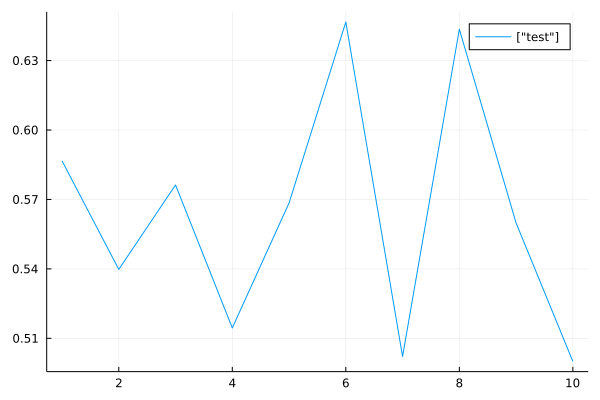

In [178]:
# Plots.plot(train_acc_list,label=["train"])
Plots.plot!(test,label=["test"])

In [146]:
"""
    In order to compute for confusion matrix
    Just from hw1
"""
#TT
TT=sum(vec(evomodel(X_test_std) .> 0.5) .== 1) 
#TF
TF=sum(vec(evomodel(X_test_std) .> 0.5) .== 0) 
#FT
FT=sum(vec(evomodel(X_test_std) .< 0.5) .== 1) 
#FF
FF=sum(vec(evomodel(X_test_std) .< 0.5) .== 0) 
println("confusion matrix of test data in best model:")
println("true_true_result->$TT,  true_false_result->$TF")
println("false_false_result->$FF,   false_true_result->$FT")

confusion matrix of test data in best model:
true_true_result->12014,  true_false_result->7599
false_false_result->9225,   false_true_result->9053
